In [147]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "white"

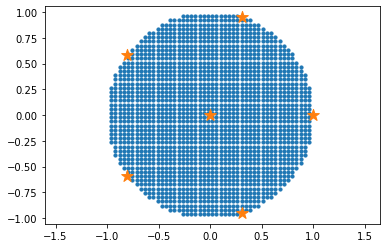

In [149]:
## make reference circle

r = 1
n_nodes = 50

x = np.linspace(-r,r,n_nodes)
y = np.linspace(-r,r,n_nodes)
xx,yy = np.meshgrid(x,y)
xx = xx.flatten()
yy = yy.flatten()
keep = xx**2 + yy**2 <= r**2
xx = xx[keep]
yy = yy[keep]

grid_crd = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))


plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            s = 10,
           )
n_L = 5
landmarks = np.array([2*l*np.pi / (n_L) for l in range(n_L) ])
landmarks = np.hstack((r*np.cos(landmarks)[:,np.newaxis],r*np.sin(landmarks)[:,np.newaxis]))
landmarks = np.append(landmarks,np.zeros((1,2)),axis=0)
ldists = cdist(grid_crd,landmarks)

plt.scatter(landmarks[:,0],
            landmarks[:,1],
            cmap = plt.cm.Set3,
            marker = "*",
            s = 150,
           )

plt.axis("equal")
plt.show()

In [14]:
z_base.max()

14.556848094739829

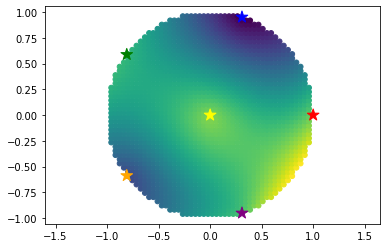

In [150]:
pattern_fun = lambda x: x[:,0]**2 + (x[:,1]*x[:,3]+1)**2 +\
x[:,4] + (1-(x[:,5]-x[:,4])**2) + 7*(1-x[:,5])
z_base = pattern_fun(ldists)
landmark_cmap = ["red","blue","green","orange","purple","yellow"]

plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            s = 25,
            c = z_base,
           )
n_L = 5

plt.scatter(landmarks[:,0],
            landmarks[:,1],
            color = landmark_cmap,
            marker = "*",
            s = 150,
           )

plt.axis("equal")
plt.show()

In [151]:
def rotate(M,theta):
    R = np.zeros((2,2))
    R[0,0] = np.cos(theta)
    R[1,0] = np.sin(theta)
    R[0,1] = -np.sin(theta)
    R[1,1] = np.cos(theta)
    return np.dot(M,R)

In [168]:
n_extra = 5
alt_landmarks = landmarks + np.random.normal(0, 0.07,
                                             size = (n_extra,landmarks.shape[0],2))
theta = np.random.uniform(0,2*np.pi,n_extra)
alt_landmarks = np.array([rotate(alt_landmarks[k,:,:],theta[k]) for k in range(n_extra)])
alt_ldists = np.zeros((n_extra,ldists.shape[0],ldists.shape[1]))
alt_vals = np.zeros((n_extra,ldists.shape[0]))

for k in range(len(alt_landmarks)):
    tmp_ldist = cdist(grid_crd,alt_landmarks[k,:,:])
    alt_ldists[k,:,:] = tmp_ldist
    alt_vals[k,:] = pattern_fun(tmp_ldist)

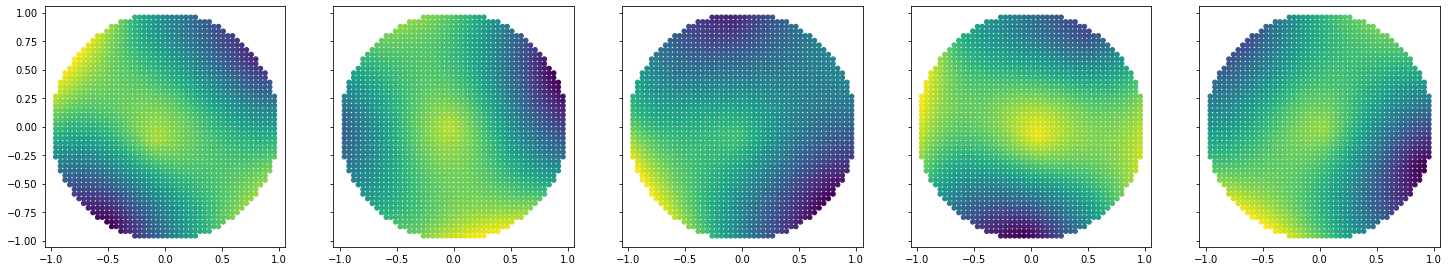

In [169]:
show_landmarks = False
fig,ax = plt.subplots(1,n_extra,
                      sharex = True,
                      sharey = True,
                      figsize = (n_extra*5,5))
ax = ax.flatten()

for k in range(len(ax)):
    ax[k].scatter(grid_crd[:,0],
                  grid_crd[:,1],
                  c = alt_vals[k,:],
                  marker = "o",
                  s = 20,
                 )
    if show_landmarks: 
        ax[k].scatter(alt_landmarks[k,:,0],
                      alt_landmarks[k,:,1],
                      s = 200,
                      c = landmark_cmap,
                     )

    ax[k].set_aspect("equal")
    
plt.show()

In [170]:
obs_index = [f"Spot_{x}" for x in range(len(grid_crd))]
adatas = []
for k in range(n_extra):
    adata = ad.AnnData(alt_vals[k,:,np.newaxis],
                       var = pd.DataFrame(["Gene1"],
                                          columns = ["Gene"],
                                          index = ["Gene1"],
                                         ),
                       obs = pd.DataFrame(index = obs_index)
                      )
    adata.obsm["spatial"] = grid_crd
    adata.obsm["landmark_distances"] = alt_ldists[k,:,:]
    adatas.append(adata)

In [165]:
ref.adata.var

,Gene
sample_0,Gene1


In [171]:
import models as m
import methods as f

ref = m.Reference(grid_crd,
                  landmarks = landmarks,
                 )

models = f.map_to_reference(adatas,
                           "Gene1",
                            ref,
                            n_epochs=100,
                           )

None
AnnData object with n_obs × n_vars = 1876 × 1


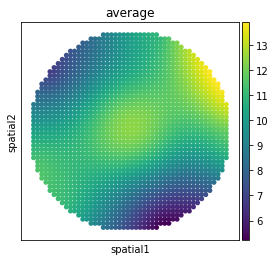

In [173]:
ref.plot(samples = "average",spot_size=0.05,ncols = 5)

In [173]:
ref.adata.var

,Gene
sample_0,Gene1
sample_1,Gene1
sample_2,Gene1
sample_3,Gene1
sample_4,Gene1


## Real Data

In [1]:
LMK_PTH = "/home/alma/w-projects/ccf/rsc/ref/reference_landmarks.tsv"
IMG_PTH = "/home/alma/w-projects/ccf/rsc/ref/mob-bw.png"

In [117]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [118]:
img = np.asarray(Image.open(IMG_PTH).convert("L"))
lmk = pd.read_csv(LMK_PTH,sep = "\t",header = 0,index_col = 0)
lmk.iloc[:,:] = lmk.iloc[:,:] * 11.5

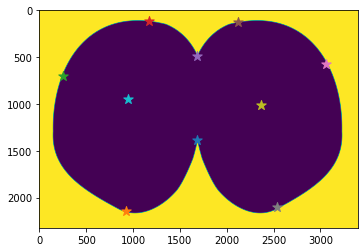

In [119]:
plt.imshow(img)
for ii in range(len(lmk)):
    plt.scatter(lmk.x_cord.values[ii],lmk.y_cord.values[ii],s = 100,marker = "*")
plt.show()

In [120]:
img = img / 255
img[img >= 0.5] = 1
img[img < 0.5] = 0
img = img.astype(np.int)
img.max()

1

In [121]:
ref_x = []
ref_y = []

for _x in range(0,img.shape[0],10):
    for _y in range(0,img.shape[1],10):
        if img[_x,_y] == 0:
            ref_x.append(_x)
            ref_y.append(_y)
            
ref_crd = np.array([ref_y,ref_x]).T
mx = np.max(ref_crd)
ref_crd = ref_crd / mx
lmk.iloc[:,:] = lmk.iloc[:,:] / mx

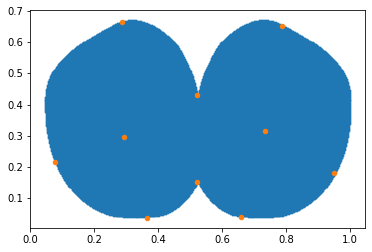

In [122]:
plt.scatter(ref_crd[:,0],ref_crd[:,1],s=0.5)
plt.scatter(lmk.x_cord,lmk.y_cord,s=20)

In [59]:
import preprocess as pp

In [175]:
ANN_PTH = "/home/alma/w-projects/ccf/data/science-mob/Rep11_MOB.h5ad"
adata = ad.read_h5ad(ANN_PTH)
sc.pp.normalize_per_cell(adata,1e4)
sc.pp.log1p(adata)
max_crd = adata.obsm["spatial"].max()
pp.get_landmark_distance(adata)


(1696.1456256723802, 8296.072884038278, 2030.5580952380956, 7152.870476190476)

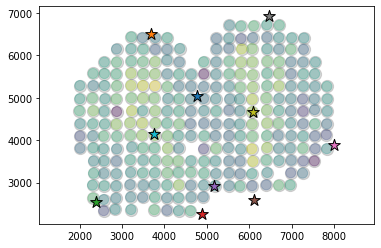

In [190]:
plt.scatter(adata.obsm["spatial"][:,0],
            adata.obsm["spatial"][:,1],
            c = "gray",
            s = 150,
            alpha = 0.3
           )

plt.scatter(adata.obsm["spatial"][:,0],
            adata.obsm["spatial"][:,1],
            c = adata.obs_vector("Penk"),
            s = 100,
            alpha = 0.3
           )

for ii in range(len(adata.uns["curated_landmarks"])):
    plt.scatter(adata.uns["curated_landmarks"][ii,0],
                adata.uns["curated_landmarks"][ii,1],
                s = 150,
                marker = "*",
                edgecolor = "black",
               )

plt.axis("equal")


In [206]:
import models as m
import methods as f

ref = m.Reference(ref_crd,
                  landmarks = lmk.values,
                 )

models = f.map_to_reference([adata],
                           "Camk2a",
                            ref,
                            n_epochs=1000,
                           )

None
AnnData object with n_obs × n_vars = 51231 × 1


In [207]:
ref.adata.X

array([[1.0502956 ],
       [1.0504595 ],
       [1.0506302 ],
       ...,
       [0.98579085],
       [0.9884326 ],
       [0.99107313]], dtype=float32)

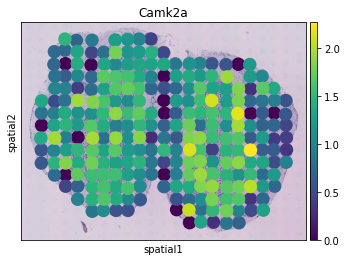

In [204]:
sc.pl.spatial(adata,color=["Camk2a"])

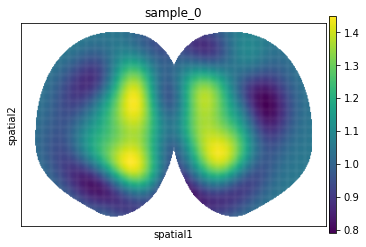

In [78]:
adata.obsm

AxisArrays with keys: spatial, landmark_distances

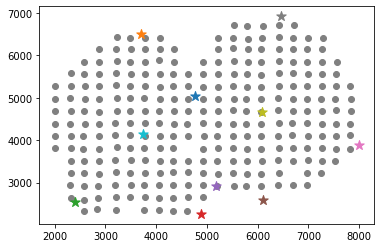

In [102]:
import scanpy as sc
plt.scatter(adata.obsm["spatial"][:,0],adata.obsm["spatial"][:,1],c = "gray")
for ii in range(len(adata.uns["curated_landmarks"])):
    plt.scatter(adata.uns["curated_landmarks"][ii,0],
                adata.uns["curated_landmarks"][ii,1],
                s = 100,
                marker = "*",
               )

In [83]:
adata.uns["spatial"]["Rep11_MOB"]["images"]

{'hires': array([[[211, 205, 219],
         [211, 205, 219],
         [211, 205, 219],
         ...,
         [211, 205, 219],
         [212, 206, 220],
         [212, 206, 220]],
 
        [[211, 205, 219],
         [211, 205, 219],
         [211, 205, 219],
         ...,
         [211, 205, 219],
         [211, 205, 219],
         [211, 205, 219]],
 
        [[211, 205, 219],
         [211, 205, 219],
         [211, 205, 219],
         ...,
         [211, 205, 219],
         [211, 205, 219],
         [211, 205, 219]],
 
        ...,
 
        [[212, 206, 220],
         [212, 206, 220],
         [212, 206, 220],
         ...,
         [212, 204, 219],
         [212, 204, 219],
         [212, 204, 219]],
 
        [[212, 206, 220],
         [212, 206, 220],
         [212, 206, 220],
         ...,
         [211, 205, 219],
         [211, 205, 219],
         [211, 205, 219]],
 
        [[212, 206, 220],
         [212, 206, 220],
         [212, 206, 220],
         ...,
         [211, 205,

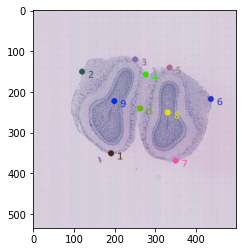

In [84]:
plt.imshow(adata.uns["spatial"]["Rep11_MOB"]["images"]["hires_landmarks"])